In [1]:
import os
from IPython.display import clear_output
os.chdir("./drive/My Drive/Colab Notebooks/SDSProject/MyProject")
os.getcwd()
os.listdir(".")

['Data',
 '.ipynb_checkpoints',
 'temp',
 'miccai18.ipynb',
 'tempData',
 'LearnResults',
 'Regroup_LOUO',
 'Regroup_LOSO',
 'Regroup_LOSAUO',
 'LOUO',
 'LOSO',
 'SDS_LOSO.ipynb',
 'SDS_REgroup_LOSO.ipynb',
 'SDS_DATAsetup_analysis.ipynb',
 'SDS_LOUO.ipynb',
 'SDS_project_Learn.ipynb',
 'SDS_REgroup_LOUO.ipynb']

In [0]:
%tensorflow_version 1.x
!pip install Scikit-learn==0.19.1
#!pip install Keras==2.1.5
#!pip install Tensorflow==1.4.1
#!pip install Numpy==1.13.3
#!pip install Pandas==0.21.1
#!pip install Matplotlib==2.0.0
#!pip install Imageio==2.2.0
#!pip install imageio
clear_output()

In [3]:
import numpy as np
import imageio
import time, os, math, re, random, io, collections
import pandas as pd
import matplotlib.pyplot as plt
import keras
from itertools import chain
from keras.models import Model
from keras.utils import np_utils
from keras import regularizers
from keras.preprocessing import sequence
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

Using TensorFlow backend.


In [4]:
#File functions
def getExpertiseLevelOfSurgery(surgery_name):
	## function getMetaDataForSurgeries should be already called
	if surgeries_metadata.__contains__(surgery_name):
		return surgeries_metadata[surgery_name][0]
	return None 
'''
#------------------------------------------------------#
#------------------Change I to E-----------------------#
#------------------------------------------------------#
def getExpertiseLevelOfSurgery(surgery_name):
  ## function getMetaDataForSurgeries should be already called
  if surgeries_metadata.__contains__(surgery_name):
    if surgeries_metadata[surgery_name][0] == 'I':
      return 'E'
    return surgeries_metadata[surgery_name][0]
  return None 
'''
def getMetaDataForSurgeries(surgery_type):
	surgeries_metadata = {}
	file = open(root_dir+surgery_type+'/'+'meta_file_'+surgery_type+'.txt','r')
	for line in file: 
		line = line.strip() ## remove spaces
	
		if len(line)==0: ## if end of file
			break

		b = line.split()
		surgery_name = b[0] 
		expertise_level = b[1]
		b = b[2:]
		scores = [int(e) for e in b]
		surgeries_metadata[surgery_name]=(expertise_level,scores)
	return surgeries_metadata

def get_trial_num(surgery_name,surgery_type):
	trial_num = surgery_name.replace(surgery_type+'_',"")[-1]
	return trial_num

def readFile(file_name,dtype,columns_to_use=None):
	X = np.loadtxt(file_name,dtype,usecols=columns_to_use)
	return X


def generateMaps(surgery_type):
	listOfSurgeries =[]
	y =[]
	path = root_dir+surgery_type+'/kinematics/AllGestures/'
	for subdir,dirs,files in os.walk(path):
		for file_name in files: 
			surgery = readFile(path+file_name,float,columns_to_use=dimensions_to_use)
			surgery_name = file_name[:-4]
			expertise_level = getExpertiseLevelOfSurgery(surgery_name)
			if expertise_level is None: 
				continue
			mapSurgeryDataBySurgeryName[surgery_name] = surgery
			mapExpertiseLevelBySurgeryName[surgery_name] = expertise_level
	return None

def fit_encoder(y_train,y_test,y_val): 
	y_train_test_val = y_train+y_test+y_val
	encoder.fit(y_train_test_val)

def convertStringClassesToBinaryClasses(y_train,y_test,y_val):
	idx_y_test = len(y_train)
	idx_y_val = len(y_train)+len(y_test)
	y_train_test_val = y_train+y_test+y_val
	y_train_test_val = encoder.transform(y_train_test_val)
	y_train_test_val = np_utils.to_categorical(y_train_test_val)
	y_train = y_train_test_val[0:idx_y_test]
	y_test = y_train_test_val[idx_y_test:idx_y_val]
	y_val = y_train_test_val[idx_y_val:]
	return y_train,y_test,y_val

def write_csv_string_in_file(file_name,csv_string):
	file = open(path_to_results+ file_name + '.csv','w')
	file.write(csv_string)
	file.close()
	return True

# shuffles train and labels 
def shuffle(x_train,y_train):
	y_train = np.array(y_train)
	y_train = y_train.reshape(len(y_train),1)
	x_train = x_train.reshape(len(x_train),1)
	x_y_train = np.concatenate((x_train,y_train), axis=1)
	np.random.shuffle(x_y_train)
	return x_y_train[:,0] , x_y_train[:,1].tolist()

#-------------------------------------------------------#
#---------------User out validation---------------------#
#-------------------------------------------------------#
'''
def validation(surgery_type = 'Suturing' , summary=False, reg =0.01, max_itr=20):
	# reg is the regularization parameter 
	# max_itr is the number of iterations to repeat the experiments
	counter = 0
  #UserOut & SuperTrialOut
	path = path_to_configurations+surgery_type +'/'+'unBalanced'+'/'+'GestureClassification'+'/'+'UserOut'
	results = "fold,iteration,macro,micro\n"
	for it in range(0,max_itr):
		for subdir,dirs,files in os.walk(path):
			# One configuration with two files Train.txt and Test.txt
			x_train = []
			y_train = []
			x_test = []
			y_test = []
			x_val = []
			y_val = []
			trial_added_to_val = None
			min_length_train = np.iinfo(np.int32).max # this is the minimum length of a training instance
			min_length_test = np.iinfo(np.int32).max # this is the minimum length of a test instance
			min_length_val = np.iinfo(np.int32).max # this is the minimum length of a val instance
			for file_name in files:
				data = readFile(subdir+'/'+file_name,str)
				surgeries_set = set()
				for gesture in data:
					surgery_name = find_pattern(gesture[0],surgery_type+'_.00.')
					surgeries_set.add(surgery_name)
	
				for surgery_name in surgeries_set:
					trial_num = get_trial_num(surgery_name,surgery_type)
					if file_name == 'Train.txt':
						if(trial_added_to_val is None):
							trial_added_to_val=trial_num
						
						if(trial_num==trial_added_to_val): 
							# we should add to validation set 
							min_length_val=min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_val)
							x_val.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_val.append(mapExpertiseLevelBySurgeryName[surgery_name])
						else: # we add to the train set 
							min_length_train = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_train)
							x_train.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_train.append(mapExpertiseLevelBySurgeryName[surgery_name])
					else:
						# we are adding to the test set
						min_length_test = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_test)
						x_test.append(mapSurgeryDataBySurgeryName[surgery_name])
						y_test.append(mapExpertiseLevelBySurgeryName[surgery_name])
				# end of one file Train or Test 
			if(len(files)>0):
	
				x_train = np.array(x_train)
				x_test = np.array(x_test)
				x_val = np.array(x_val)
	
				print('train size:'+str(len(x_train)))
				print('val size:'+str(len(x_val)))
				print('test size:'+str(len(x_test)))
	
				fit_encoder(y_train,y_test,y_val)
	
				model = each_dim_build_model(input_shapes,summary=summary,reg =reg)
				
				fold = find_pattern(subdir,'UserOut'+'/.*_Out').replace('UserOut'+'/','').replace('_Out','')
				iteration = find_pattern(subdir, 'itr_.*').replace('itr_','')
				# we train on each training instance 
					
				y_test = fitModel(model,x_train,y_train,x_test,y_test,x_val,y_val)	
					
				model = load_model('LearnResults/model.h5')# reload the best model saved 

				# uncomment if you want to visualize the class activiation map as a gif 
				# generate_class_activation_map_for_all_surgeries(model,fold)
				
				# evaluate model and get results for confusion matrix 
				(macro,micro) = evaluateModel(model,x_test,y_test)
				results += fold+','+str(it)+','+str(macro)+','+str(micro)+'\n'
	
			# end of one configuration 
	matrix = confusion_matrix.to_numpy()
	macro = compute_macro(matrix)
	micro = compute_micro(matrix)
	results += 'total,total,'+str(macro)+','+str(micro)+'\n'
	results_file_name = 'results'
	return write_csv_string_in_file(results_file_name,results)
'''

def validation(surgery_type = 'Suturing' , summary=False, reg =0.01, max_itr=20):
	# reg is the regularization parameter 
	# max_itr is the number of iterations to repeat the experiments
	counter = 0
	#UserOut & SuperTrialOut
	path = path_to_configurations+surgery_type +'/'+'unBalanced'+'/'+'GestureClassification'+'/'+'SuperTrialOut'
	results = "fold,iteration,macro,micro\n"
	for it in range(0,max_itr):
		for subdir,dirs,files in os.walk(path):
			# One configuration with two files Train.txt and Test.txt
			x_train = []
			y_train = []
			x_test = []
			y_test = []
			x_val = []
			y_val = []
			trial_added_to_val = None
			min_length_train = np.iinfo(np.int32).max # this is the minimum length of a training instance
			min_length_test = np.iinfo(np.int32).max # this is the minimum length of a test instance
			min_length_val = np.iinfo(np.int32).max # this is the minimum length of a val instance
			for file_name in files:
				data = readFile(subdir+'/'+file_name,str)
				surgeries_set = set()
				for gesture in data:
					surgery_name = find_pattern(gesture[0],surgery_type+'_.00.')
					surgeries_set.add(surgery_name)
	
				for surgery_name in surgeries_set:
					trial_num = get_trial_num(surgery_name,surgery_type)
					if file_name == 'Train.txt':
						if(trial_added_to_val is None):
							trial_added_to_val=trial_num
						
						if(trial_num==trial_added_to_val): 
							# we should add to validation set 
							min_length_val=min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_val)
							x_val.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_val.append(mapExpertiseLevelBySurgeryName[surgery_name])
						else: # we add to the train set 
							min_length_train = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_train)
							x_train.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_train.append(mapExpertiseLevelBySurgeryName[surgery_name])
					else:
						# we are adding to the test set
						min_length_test = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_test)
						x_test.append(mapSurgeryDataBySurgeryName[surgery_name])
						y_test.append(mapExpertiseLevelBySurgeryName[surgery_name])
				# end of one file Train or Test 
			if(len(files)>0):
	
				x_train = np.array(x_train)
				x_test = np.array(x_test)
				x_val = np.array(x_val)
	
				print('train size:'+str(len(x_train)))
				print('val size:'+str(len(x_val)))
				print('test size:'+str(len(x_test)))
	
				fit_encoder(y_train,y_test,y_val)
	
				model = each_dim_build_model(input_shapes,summary=summary,reg =reg)
				
				fold = find_pattern(subdir,'SuperTrialOut'+'/.*_Out').replace('SuperTrialOut'+'/','').replace('_Out','')
				iteration = find_pattern(subdir, 'itr_.*').replace('itr_','')
				# we train on each training instance 
					
				y_test = fitModel(model,x_train,y_train,x_test,y_test,x_val,y_val)	
					
				model = load_model('LearnResults/model.h5')# reload the best model saved 

				# uncomment if you want to visualize the class activiation map as a gif 
				# generate_class_activation_map_for_all_surgeries(model,fold)
				
				# evaluate model and get results for confusion matrix 
				(macro,micro) = evaluateModel(model,x_test,y_test)
				results += fold+','+str(it)+','+str(macro)+','+str(micro)+'\n'
	
			# end of one configuration 
	matrix = confusion_matrix.to_numpy()
	macro = compute_macro(matrix)
	micro = compute_micro(matrix)
	results += 'total,total,'+str(macro)+','+str(micro)+'\n'
	results_file_name = 'results'
	return write_csv_string_in_file(results_file_name,results)

def find_pattern(word,pattern):
	return re.search(r''+pattern,word).group(0)

def compute_micro(matrix):
	return sum(matrix.diagonal()) / np.sum(matrix)

def compute_macro(matrix):
	res = matrix.diagonal()/np.sum(matrix,axis=1)
	return np.nansum(res)/float(nb_classes)

# the sequence variable is the multivariate time series or in this case the surgical task
# we want to split the inputs in order to train  
def split_input_for_training(sequence):
	# get number of hands 
	num_hands= len(input_shapes)
	# get number of dimensions cluster for each hand 
	num_dim_clusters = len(input_shapes[0])
	# define the new input sequence 
	x = []
	# this is used to keep track of the assigned dimensions 
	last = 0
	# loop over each hand 
	for i in range(num_hands):
		# loop for each hand over the cluster of dimensions 
		for j in range(num_dim_clusters): 
			# assign new input same length but different dimensions each time 
			x.append(np.array([sequence[:,last:(last+input_shapes[i][j][1])]]))
			# remember last assigned 
			last= input_shapes[i][j][1]
	# return the new input 
	return x                              

def each_dim_build_model(input_shapes,summary=False, reg=0.00001): 
	# get number of hands 
	num_hands= len(input_shapes)
	# get number of dimensions cluster for each hand 
	num_dim_clusters = len(input_shapes[0])
	# first index for hand second for  dims
	x =[[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# first conv layer on each dim cluster for each hand 
	conv1 = [[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# merged layers for each hand 
	hand_layers =[None for a in range(num_hands)]
	# second conv layer on concatenated conv1 for each hand
	conv2 = [None for a in range(num_hands)] 
	# loop over each hand 
	for i in range(0,num_hands): 
		# loop for each hand over the dimension (or channels) clusters 
		for j in range(0,num_dim_clusters): 
			# input layer for each dimension cluster for each hand 
			x[i][j]=keras.layers.Input(input_shapes[i][j])
			# first conv layer over the clustered dimensions or channels in terms of keras 
			conv1[i][j] = keras.layers.Conv1D(8,kernel_size=3,strides=1,padding='same', activity_regularizer=regularizers.l2(reg))(x[i][j])
			conv1[i][j] = keras.layers.Activation('relu')(conv1[i][j])
		# concatenate convolutions of first layer over the channels dimension for each hand 
		hand_layers[i]=keras.layers.Concatenate(axis=-1)(conv1[i])
		# do a second convolution over features extracted from the first convolution over each hand 
		conv2[i] = keras.layers.Conv1D(16,kernel_size=3, strides=1, padding='same', activity_regularizer=regularizers.l2(reg))(hand_layers[i])
		conv2[i] = keras.layers.Activation('relu')(conv2[i])
	# concatenate the features of the two hands 
	final_input = keras.layers.Concatenate(axis=-1)(conv2) 
	# do a final convolution over the features concatenated for all hands 
	conv3 = keras.layers.Conv1D(32,kernel_size=3,strides=1,padding='same', activity_regularizer = regularizers.l2(reg))(final_input)
	conv3 = keras.layers.Activation('relu', name = "conv_final")(conv3)
	# do a globla average pooling of the final convolution 
	pooled = keras.layers.GlobalAveragePooling1D()(conv3)
	# add the final softmax classifier layer 
	out = keras.layers.Dense(nb_classes,activation='softmax')(pooled)
	# create the model and link input to output 
	model = Model(inputs=list(chain.from_iterable(x)),outputs=out)
	# show summary if specified 
	if summary==True : 
		model.summary()

	# choose the optimizer 
	optimizer = keras.optimizers.Adam()
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

	return model

def fitModel(model,x_train,y_train,x_test,y_test,x_val,y_val):
	# x_test and y_test are used to monitor the overfitting / underfitting not for training 
	# minimum epoch loss on val set
	min_val_loss =  np.iinfo(np.int32).max 
	# train for many epochs as specified by nb_epochs
	for epoch in range(0,nb_epochs) : 
		# shuffle before every epoch training 
		x_train,y_train=shuffle(x_train,y_train)
		#convert string labels to binary forms
		y_train_binary,y_test_binary,y_val_binary = convertStringClassesToBinaryClasses(y_train,y_test,y_val)
		# train each sequence alone
		epoch_val_loss, epoch_val_acc, epoch_tra_loss, epoch_tra_acc = 0, 0, 0, 0
		for sequence,label in zip(x_train,y_train_binary):
			model.train_on_batch(split_input_for_training(sequence),label.reshape(1,nb_classes))
			
		epoch_tra_loss, epoch_tra_acc = evaluate_for_epoch(model,x_train,y_train_binary)
		epoch_val_loss, epoch_val_acc = evaluate_for_epoch(model,x_val,y_val_binary)
		print("acc : t/v", epoch_tra_acc, epoch_val_acc)
		print("loss: t/v", epoch_tra_loss, epoch_val_loss)
		if(epoch_val_loss < min_val_loss): # this is to choose finally the model that yields the best results on the validation set 
			model.save('LearnResults/model.h5')
			min_val_loss= epoch_val_loss
	return y_test_binary


def fitModel_curve(model,x_train,y_train,x_test,y_test,x_val,y_val):
	# x_test and y_test are used to monitor the overfitting / underfitting not for training 
	# minimum epoch loss on val set
	min_val_loss =  np.iinfo(np.int32).max 
	curve_acc = [[],[]]
	curve_loss = [[],[]]
  # train for many epochs as specified by nb_epochs
	for epoch in range(0,nb_epochs) : 
		# shuffle before every epoch training 
		x_train,y_train=shuffle(x_train,y_train)
		#convert string labels to binary forms
		y_train_binary,y_test_binary,y_val_binary = convertStringClassesToBinaryClasses(y_train,y_test,y_val)
		# train each sequence alone
		epoch_val_loss, epoch_val_acc, epoch_tra_loss, epoch_tra_acc = 0, 0, 0, 0
		for sequence,label in zip(x_train,y_train_binary):
			model.train_on_batch(split_input_for_training(sequence),label.reshape(1,nb_classes))
			
		epoch_tra_loss, epoch_tra_acc = evaluate_for_epoch(model,x_train,y_train_binary)
		epoch_val_loss, epoch_val_acc = evaluate_for_epoch(model,x_val,y_val_binary)
		print("acc : t/v", epoch_tra_acc, epoch_val_acc)
		print("loss: t/v", epoch_tra_loss, epoch_val_loss)
		curve_acc[0].append(epoch_tra_acc)
		curve_acc[1].append(epoch_val_acc)
		curve_loss[0].append(epoch_tra_loss)
		curve_loss[1].append(epoch_val_loss)
		if(epoch_val_loss < min_val_loss): # this is to choose finally the model that yields the best results on the validation set 
			model.save('LearnResults/model.h5')
			min_val_loss= epoch_val_loss
	return y_test_binary, curve_acc, curve_loss

def evaluate_for_epoch(model,x_test,y_test):
	epoch_test_loss, epoch_test_acc = 0, 0
	for test,label in zip(x_test,y_test):
		loss , acc = model.evaluate(split_input_for_training(test), label.reshape(1,nb_classes), verbose=0)
		epoch_test_loss += loss ############### change if monitor acc instead of loss
		epoch_test_acc += acc ############### change if monitor acc instead of loss
	return epoch_test_loss/len(x_test), epoch_test_acc/len(x_test)

def evaluateModel(model,x_test,y_test):
	confusion_matrix_f = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) 

	for test,label in zip(x_test,y_test):
		loss , acc = model.evaluate(split_input_for_training(test), label.reshape(1,nb_classes), verbose=0)
		p = model.predict(split_input_for_training(test), batch_size = 1)
		predicted_integer_label = np.argmax(p).astype(int)
		predicted_label = encoder.inverse_transform(predicted_integer_label)
		correct_label = encoder.inverse_transform(np.argmax(label))
		confusion_matrix[correct_label][predicted_label]+=1.0
		confusion_matrix_f[correct_label][predicted_label]+=1.0

	matrix_f = confusion_matrix_f.to_numpy()
	macro = compute_macro(matrix_f)
	return (macro,compute_micro(matrix_f))

'''
#deprecated version
def evaluateModel(model,x_test,y_test):
	confusion_matrix_f = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) 

	for test,label in zip(x_test,y_test):
		loss , acc = model.evaluate(split_input_for_training(test), label.reshape(1,nb_classes), verbose=0)
		p = model.predict(split_input_for_training(test), batch_size = 1)
		predicted_integer_label = np.argmax(p).astype(int)
		print(p)
		print(predicted_integer_label)
		predicted_label = encoder.inverse_transform(predicted_integer_label)
		correct_label = encoder.inverse_transform(np.argmax(label))
		confusion_matrix[correct_label][predicted_label]+=1.0
		confusion_matrix_f[correct_label][predicted_label]+=1.0

	matrix_f = confusion_matrix_f.as_matrix()
	macro = compute_macro(matrix_f)
	return (macro,compute_micro(matrix_f))
'''

'\n#deprecated version\ndef evaluateModel(model,x_test,y_test):\n\tconfusion_matrix_f = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) \n\n\tfor test,label in zip(x_test,y_test):\n\t\tloss , acc = model.evaluate(split_input_for_training(test), label.reshape(1,nb_classes), verbose=0)\n\t\tp = model.predict(split_input_for_training(test), batch_size = 1)\n\t\tpredicted_integer_label = np.argmax(p).astype(int)\n\t\tprint(p)\n\t\tprint(predicted_integer_label)\n\t\tpredicted_label = encoder.inverse_transform(predicted_integer_label)\n\t\tcorrect_label = encoder.inverse_transform(np.argmax(label))\n\t\tconfusion_matrix[correct_label][predicted_label]+=1.0\n\t\tconfusion_matrix_f[correct_label][predicted_label]+=1.0\n\n\tmatrix_f = confusion_matrix_f.as_matrix()\n\tmacro = compute_macro(matrix_f)\n\treturn (macro,compute_micro(matrix_f))\n'

In [5]:
# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/LearnResults/'
nb_epochs = 5
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Suturing'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name 
#classes = ['N','E']
classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))

Number of different surgeries in total: 39


epochs setting:  20
train size:23
val size:8
test size:8
4
5

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
acc : t/v 0.6521739130434783 0.625
loss: t/v 1.6984834411869878 1.5375921726226807
acc : t/v 0.4782608695652174 0.5
loss: t/v 1.4717111613439477 1.352959468960762
acc : t/v 0.6521739130434783 0.625
loss: t/v 1.3291730258775794 1.2576363235712051
acc : t/v 0.6521739130434783 0.625
loss: t/v 1.2019106978955476 1.1520115360617638
acc : t/v 0.6521739130434783 0.625
loss: t/v 1.1156194339627805 1.0767729952931404
acc : t/v 0.7391304347826086 0.75
loss: t/v 1.0682093760241633 1.055986076593399
acc : t/v 0.782608695652174 0.75
loss: t/v 0.9922078329583873 0.9802251979708672
acc : t/v 0.7391304347826086 0.75
loss: t/v 0.9585216693256212 0.9550699293613434
acc : t/v 0.8695652173913043 0.75
loss: t/v 0.8716750468896783 0.8640469014644623
acc : t/v 0.7391304347826086 0.75
loss: t/v 0.8338202626808829 0.8186425231397152
acc

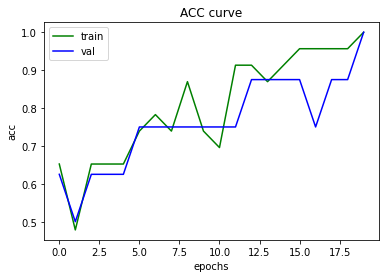

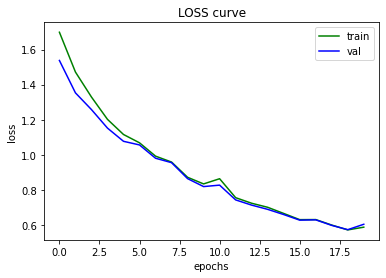

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

fold,iteration,macro,micro
3,0,1.0,1.0
total,total,0.9090909090909092,0.8125

      N    I    E
N  16.0  4.0  2.0
I   0.0  4.0  0.0
E   0.0  0.0  6.0


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [10]:
#Validation test
#(surgery_type,reg = 0.00001,summary=False,max_itr=1)
nb_epochs = 20
it=0
print("epochs setting: ", nb_epochs)
surgery_type = 'Suturing' 
summary=False
reg =0.00001
# reg is the regularization parameter 
# max_itr is the number of iterations to repeat the experiments
counter = 0
#UserOut & SuperTrialOut
path = path_to_configurations+surgery_type +'/'+'unBalanced'+'/'+'GestureClassification'+'/'+'SuperTrialOut'
results = "fold,iteration,macro,micro\n"
for subdir,dirs,files in os.walk(path):
  # One configuration with two files Train.txt and Test.txt
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  x_val = []
  y_val = []
  trial_added_to_val = None
  min_length_train = np.iinfo(np.int32).max # this is the minimum length of a training instance
  min_length_test = np.iinfo(np.int32).max # this is the minimum length of a test instance
  min_length_val = np.iinfo(np.int32).max # this is the minimum length of a val instance
  for file_name in files:
    data = readFile(subdir+'/'+file_name,str)
    surgeries_set = set()
    for gesture in data:
      surgery_name = find_pattern(gesture[0],surgery_type+'_.00.')
      surgeries_set.add(surgery_name)

    for surgery_name in surgeries_set:
      trial_num = get_trial_num(surgery_name,surgery_type)
      if file_name == 'Train.txt':
        if(trial_added_to_val is None):
          trial_added_to_val=trial_num
        
        if(trial_num==trial_added_to_val): 
          # we should add to validation set 
          min_length_val=min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_val)
          x_val.append(mapSurgeryDataBySurgeryName[surgery_name])
          y_val.append(mapExpertiseLevelBySurgeryName[surgery_name])
        else: # we add to the train set 
          min_length_train = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_train)
          x_train.append(mapSurgeryDataBySurgeryName[surgery_name])
          y_train.append(mapExpertiseLevelBySurgeryName[surgery_name])
      else:
        # we are adding to the test set
        min_length_test = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_test)
        x_test.append(mapSurgeryDataBySurgeryName[surgery_name])
        y_test.append(mapExpertiseLevelBySurgeryName[surgery_name])
    # end of one file Train or Test 
  if(len(files)>0):

    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_val = np.array(x_val)

    print('train size:'+str(len(x_train)))
    print('val size:'+str(len(x_val)))
    print('test size:'+str(len(x_test)))


    fit_encoder(y_train,y_test,y_val)

    model = each_dim_build_model(input_shapes,summary=summary,reg =reg)
    
    fold = find_pattern(subdir,'SuperTrialOut'+'/.*_Out').replace('SuperTrialOut'+'/','').replace('_Out','')
    iteration = find_pattern(subdir, 'itr_.*').replace('itr_','')
    # we train on each training instance 
    
    y_test, curve_acc, curve_loss = fitModel_curve(model,x_train,y_train,x_test,y_test,x_val,y_val)	
    #print(curve_acc)
    
    plt.plot(curve_acc[0], color = 'g', label='train')
    plt.plot(curve_acc[1], color = 'blue', label='val')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title("ACC curve")
    plt.show()

    plt.plot( curve_loss[0], color = 'g', label='train')
    plt.plot( curve_loss[1], color = 'blue', label='val')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title("LOSS curve")
    plt.show()
    
    model = load_model('LearnResults/model.h5')# reload the best model saved 

    # uncomment if you want to visualize the class activiation map as a gif 
    # generate_class_activation_map_for_all_surgeries(model,fold)
    
    # evaluate model and get results for confusion matrix 
    (macro,micro) = evaluateModel(model,x_test,y_test)
    results += fold+','+str(it)+','+str(macro)+','+str(micro)+'\n'
    break

  # end of one configuration 
matrix = confusion_matrix.to_numpy()
macro = compute_macro(matrix)
micro = compute_micro(matrix)
results += 'total,total,'+str(macro)+','+str(micro)+'\n'
results_file_name = 'results'
print(results)
print(confusion_matrix)

In [0]:
#Drop out version
def each_dim_build_model(input_shapes,summary=True, reg=0.00001): 
	# get number of hands 
	num_hands= len(input_shapes)
	print(num_hands)
	# get number of dimensions cluster for each hand 
	num_dim_clusters = len(input_shapes[0])
	print(num_dim_clusters)
  # first index for hand second for  dims
	x =[[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# first conv layer on each dim cluster for each hand 
	conv1 = [[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# merged layers for each hand 
	hand_layers =[None for a in range(num_hands)]
	# second conv layer on concatenated conv1 for each hand
	conv2 = [None for a in range(num_hands)] 
	# loop over each hand 
	for i in range(0,num_hands): 
		# loop for each hand over the dimension (or channels) clusters 
		for j in range(0,num_dim_clusters): 
			# input layer for each dimension cluster for each hand 
			x[i][j]=keras.layers.Input(input_shapes[i][j])
			# first conv layer over the clustered dimensions or channels in terms of keras 
			conv1[i][j] = keras.layers.Conv1D(8,kernel_size=3,strides=1,padding='same', activity_regularizer=regularizers.l2(reg))(x[i][j])
			conv1[i][j] = keras.layers.Activation('relu')(conv1[i][j])
		# concatenate convolutions of first layer over the channels dimension for each hand 
		hand_layers[i]=keras.layers.Concatenate(axis=-1)(conv1[i])
		# do a second convolution over features extracted from the first convolution over each hand 
		conv2[i] = keras.layers.Conv1D(16,kernel_size=3, strides=1, padding='same', activity_regularizer=regularizers.l2(reg))(hand_layers[i])
		conv2[i] = keras.layers.Activation('relu')(conv2[i])
	# concatenate the features of the two hands 
	final_input = keras.layers.Concatenate(axis=-1)(conv2) 
	# do a final convolution over the features concatenated for all hands 
	conv3 = keras.layers.Conv1D(32,kernel_size=3,strides=1,padding='same', activity_regularizer = regularizers.l2(reg))(final_input)
	conv3 = keras.layers.Activation('relu', name = "conv_final")(conv3)
	# do a globla average pooling of the final convolution 
	pooled = keras.layers.GlobalAveragePooling1D()(conv3)
	#add drop out 
	drop = keras.layers.Dropout(0.3)(pooled)
	# add the final softmax classifier layer 
	out = keras.layers.Dense(nb_classes,activation='softmax')(drop)
	# create the model and link input to output 
	model = Model(inputs=list(chain.from_iterable(x)),outputs=out)
	# show summary if specified 
	if summary==True : 
		model.summary()
		print(model.summary())

	# choose the optimizer 
	optimizer = keras.optimizers.Adam()
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

	return model

In [0]:
#time 
start_time = time.time()

# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/LearnResults/'
nb_epochs = 50
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Suturing'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name 
#classes = ['N','E']
classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))


validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")

In [0]:
#------------------------------------------------------#
#------------------Change I to E-----------------------#
#------------------------------------------------------#
def getExpertiseLevelOfSurgery(surgery_name):
  ## function getMetaDataForSurgeries should be already called
  if surgeries_metadata.__contains__(surgery_name):
    if surgeries_metadata[surgery_name][0] == 'I':
      return 'E'
    return surgeries_metadata[surgery_name][0]
  return None 